In [0]:
! pip install -U segmentation-models==0.2.1

     |████████████████████████████████| 51kB 2.0MB/s 
     |████████████████████████████████| 81kB 4.7MB/s 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from imutils import paths
from segmentation_models import Unet
from segmentation_models.utils import set_trainable
from tqdm import tqdm
import numpy as np
import cv2
import gc
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
# Load the TensorBoard notebook extension
from keras.callbacks import TensorBoard
%load_ext tensorboard
import tensorflow as tf
import datetime, os
from keras.callbacks import EarlyStopping

from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [0]:
def IoU(y_val, y_pred):
    class_iou = []
    n_classes = 8
    
    y_predi = np.argmax(y_pred, axis=3)
    y_truei = np.argmax(y_val, axis=3)
    
    for c in range(n_classes):
        TP = np.sum((y_truei == c) & (y_predi == c))
        FP = np.sum((y_truei != c) & (y_predi == c))
        FN = np.sum((y_truei == c) & (y_predi != c)) 
        IoU = TP / float(TP + FP + FN)
        if(float(TP + FP + FN) == 0):
          IoU=TP/0.001
        class_iou.append(IoU)
    MIoU=sum(class_iou)/n_classes
    return MIoU
def miou( y_true, y_pred ) :
    score = tf.py_function( lambda y_true, y_pred : IoU( y_true, y_pred).astype('float32'),
                        [y_true, y_pred],
                        'float32')
    return score

In [0]:
model = Unet(backbone_name='vgg16', classes=8, activation='softmax', encoder_freeze=True, encoder_weights='imagenet')
model.compile('Adam', loss="categorical_crossentropy", metrics=['accuracy',miou])
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "u-vgg16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
___________________________

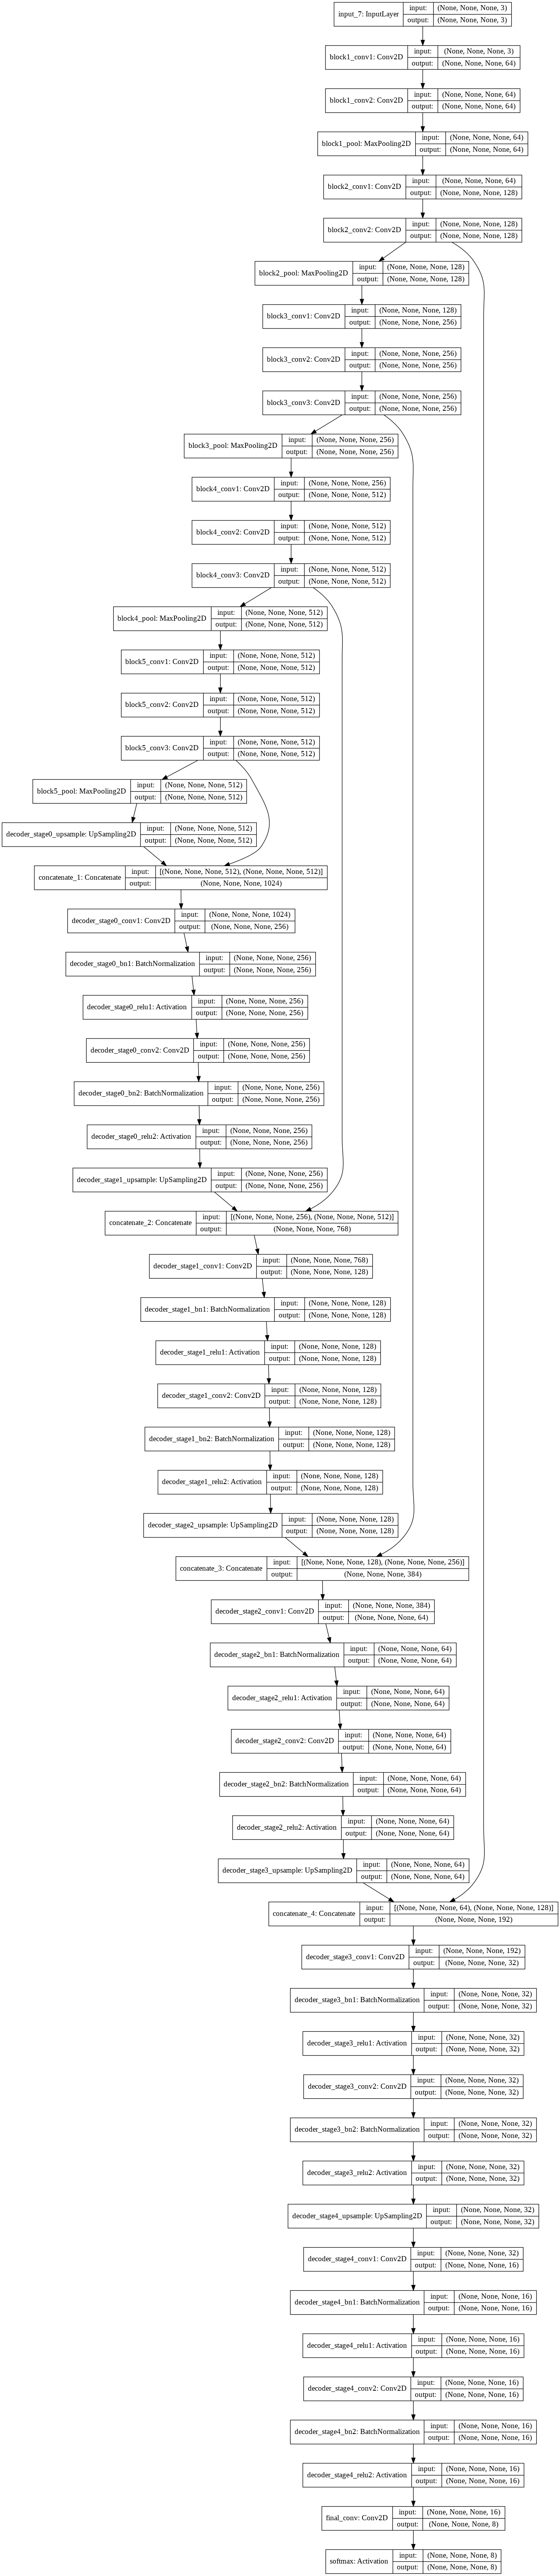

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='PSP.png', show_shapes=True, show_layer_names=True)

In [0]:
%cd /content/drive/My Drive/IDD

/content/drive/My Drive/IDD


In [0]:
from imutils import paths
from tqdm import tqdm
labels_path = paths.list_images("/content/drive/My Drive/IDD/JSON_IMG/Val_Label")
labels_path = sorted(labels_path)


import cv2
from keras.utils.np_utils import to_categorical
import numpy as np
colors = np.array([
    [0,1,0,0,0,0,0,0],      # Drivable
    [0,0,1,0,0,0,0,0],     # Non Drivable
    [0,0,0,1,0,0,0,0],      # Living Things
    [0,0,0,0,1,0,0,0],        # Vehicles
    [0,0,0,0,0,1,0,0],     # Road Side Objects
    [0,0,0,0,0,0,1,0],       # Far Objects
    [0,0,0,0,0,0,0,1],     # Sky
    [1,0,0,0,0,0,0,0]           # Misc
], dtype=np.int)

image_y_cv = []
for name in tqdm(labels_path):
  image = cv2.imread(name)
  image = cv2.resize(image, (256, 256))
  r,g,b =cv2.split(image)
  color_image = np.zeros(
        (r.shape[0], r.shape[1], 8), dtype=np.int)
  for i in range(8):
    color_image[r == i] = colors[i]
  image_y_cv.append(color_image)

from imutils import paths
x_path = paths.list_images("/content/drive/My Drive/IDD/leftImg8bit/val")
x_path = sorted(x_path)

import cv2
image_cv = []
for name in tqdm(x_path):
  image = cv2.imread(name)
  image_cv.append(cv2.resize(image, (256, 256))/255)

import numpy as np
image_cv = np.array(image_cv)
image_y_cv = np.array(image_y_cv)
image_y_cv.shape,image_cv.shape

  



100%|██████████| 1055/1055 [06:54<00:00,  2.55it/s]


((1055, 256, 256, 8), (1055, 256, 256, 3))

In [0]:
from imutils import paths
x_path = paths.list_images("/content/drive/My Drive/IDD/leftImg8bit/train")
x_path = sorted(x_path)
x_path[:5]
from imutils import paths
labels_path = paths.list_images("/content/drive/My Drive/IDD/JSON_IMG/Train_Label")
labels_path = sorted(labels_path)
#labels_path = labels_path[:2001]
labels_path[:5],x_path[:5],len(labels_path),len(x_path)

(['/content/drive/My Drive/IDD/JSON_IMG/Train_Label/201_frame0029_gtFine_polygons.png',
  '/content/drive/My Drive/IDD/JSON_IMG/Train_Label/201_frame0299_gtFine_polygons.png',
  '/content/drive/My Drive/IDD/JSON_IMG/Train_Label/201_frame0779_gtFine_polygons.png',
  '/content/drive/My Drive/IDD/JSON_IMG/Train_Label/201_frame1019_gtFine_polygons.png',
  '/content/drive/My Drive/IDD/JSON_IMG/Train_Label/201_frame1469_gtFine_polygons.png'],
 ['/content/drive/My Drive/IDD/leftImg8bit/train/201/frame0029_leftImg8bit.jpg',
  '/content/drive/My Drive/IDD/leftImg8bit/train/201/frame0299_leftImg8bit.jpg',
  '/content/drive/My Drive/IDD/leftImg8bit/train/201/frame0779_leftImg8bit.jpg',
  '/content/drive/My Drive/IDD/leftImg8bit/train/201/frame1019_leftImg8bit.jpg',
  '/content/drive/My Drive/IDD/leftImg8bit/train/201/frame1469_leftImg8bit.jpg'],
 7034,
 7034)

In [0]:
import cv2
import gc
import numpy as np
from tqdm import tqdm
colors = np.array([
    [0,1,0,0,0,0,0,0],      
    [0,0,1,0,0,0,0,0],     
    [0,0,0,1,0,0,0,0],      
    [0,0,0,0,1,0,0,0],        
    [0,0,0,0,0,1,0,0],    
    [0,0,0,0,0,0,1,0],      
    [0,0,0,0,0,0,0,1],     
    [1,0,0,0,0,0,0,0]           
], dtype=np.int)
#global block
block = 0
def train_label():
  global block
  image_y = []
  if block + 200 <= 7034:
    for name in tqdm(labels_path[block:block + 200]):
      image = cv2.imread(name)
      image = cv2.resize(image, (256, 256))
      r,g,b =cv2.split(image)
      color_image = np.zeros(
        (r.shape[0], r.shape[1], 8), dtype=np.int)
      for i in range(8):
        color_image[r == i] = colors[i]

      image_y.append(color_image)
    block = block + 200
  elif block < 7034:
      for name in labels_path[block:]:
        image = cv2.imread(name)
        image = cv2.resize(image, (256, 256))
        r,g,b =cv2.split(image)
        color_image = np.zeros((r.shape[0], r.shape[1], 8), dtype=np.int)
        for i in range(8):
          color_image[r == i] = colors[i]
        image_y.append(color_image)
      block = 0
  else:
    block = 0
    for name in tqdm(labels_path[block:block + 200]):
      image = cv2.imread(name)
      image = cv2.resize(image, (256, 256))
      r,g,b =cv2.split(image)
      color_image = np.zeros((r.shape[0], r.shape[1], 8), dtype=np.int)
      for i in range(8):
        color_image[r == i] = colors[i]
      image_y.append(color_image)
    block = block + 200
  image_y = np.array(image_y)
  collected = gc.collect()  
  print("Garbage collector: collected", 
          "%d objects." % collected)
  return image_y


  


In [0]:
import cv2
block_1 = 0
def train():
  collected = gc.collect()
  print("Garbage collector: collected","%d objects." % collected) 
  global block_1
  image_tr = []
  if block_1 + 200 <= 7034:
    for name in tqdm(x_path[block_1:block_1 + 200]):
      image = cv2.imread(name)
      img = cv2.resize(image, (256, 256))
      img = np.float32(img)  / 255 
      image_tr.append(img)
    block_1 = block_1 + 200
  elif block_1 < 7034:
    for name in tqdm(x_path[block_1:]):
      image = cv2.imread(name)
      img = cv2.resize(image, (256, 256))
      img = np.float32(img)  / 255 
      image_tr.append(img)
    block_1 = 0
  else:
    block_1 = 0
    for name in tqdm(x_path[block_1:block_1 + 200]):
      image = cv2.imread(name)
      img = cv2.resize(image, (256, 256))
      img = np.float32(img)  / 255
      image_tr.append(img)
    block_1 = block_1 + 200
  image_tr = np.array(image_tr)
  return image_tr 





In [0]:
flag = 36
history_1 = []
while(flag):
  x  = train()  
  y = train_label()
  history = model.fit(x,y,batch_size=5,epochs = 3,validation_data=(image_cv,image_y_cv))
  history_1.append(history)
  flag = flag - 1



  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 682 objects.


100%|██████████| 200/200 [00:52<00:00,  3.80it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
130/200 [==================>...........] - ETA: 10s - loss: 1.0634 - accuracy: 0.6992 - miou: 0.2575

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


200/200 [==============================] - 65s 327ms/step - loss: 0.8930 - accuracy: 0.7431 - miou: 0.2749 - val_loss: 1.7461 - val_accuracy: 0.7070 - val_miou: 0.2464
Epoch 2/3
200/200 [==============================] - 54s 270ms/step - loss: 0.5086 - accuracy: 0.8342 - miou: 0.3472 - val_loss: 0.7727 - val_accuracy: 0.7335 - val_miou: 0.2737
Epoch 3/3
200/200 [==============================] - 54s 270ms/step - loss: 0.4291 - accuracy: 0.8499 - miou: 0.3814 - val_loss: 1.0976 - val_accuracy: 0.7002 - val_miou: 0.2813


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:53<00:00,  3.77it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 55s 273ms/step - loss: 0.4513 - accuracy: 0.8447 - miou: 0.4022 - val_loss: 0.6600 - val_accuracy: 0.7824 - val_miou: 0.3631
Epoch 2/3
200/200 [==============================] - 55s 273ms/step - loss: 0.3883 - accuracy: 0.8662 - miou: 0.4380 - val_loss: 0.6548 - val_accuracy: 0.7735 - val_miou: 0.3662
Epoch 3/3
200/200 [==============================] - 55s 273ms/step - loss: 0.3539 - accuracy: 0.8797 - miou: 0.4552 - val_loss: 0.5836 - val_accuracy: 0.7972 - val_miou: 0.3936


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:53<00:00,  3.73it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 55s 273ms/step - loss: 0.5906 - accuracy: 0.7877 - miou: 0.4078 - val_loss: 0.7310 - val_accuracy: 0.7725 - val_miou: 0.3442
Epoch 2/3
200/200 [==============================] - 54s 272ms/step - loss: 0.5085 - accuracy: 0.8197 - miou: 0.4419 - val_loss: 0.5817 - val_accuracy: 0.8030 - val_miou: 0.3795
Epoch 3/3
200/200 [==============================] - 55s 273ms/step - loss: 0.4679 - accuracy: 0.8333 - miou: 0.4577 - val_loss: 0.5330 - val_accuracy: 0.8154 - val_miou: 0.3965


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:54<00:00,  3.66it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 55s 273ms/step - loss: 0.5404 - accuracy: 0.8036 - miou: 0.4064 - val_loss: 0.6085 - val_accuracy: 0.7954 - val_miou: 0.3747
Epoch 2/3
200/200 [==============================] - 54s 271ms/step - loss: 0.5046 - accuracy: 0.8152 - miou: 0.4129 - val_loss: 0.5677 - val_accuracy: 0.7878 - val_miou: 0.3804
Epoch 3/3
200/200 [==============================] - 54s 270ms/step - loss: 0.4542 - accuracy: 0.8331 - miou: 0.4336 - val_loss: 0.4659 - val_accuracy: 0.8325 - val_miou: 0.4151


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:53<00:00,  3.74it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 55s 273ms/step - loss: 0.4600 - accuracy: 0.8380 - miou: 0.4213 - val_loss: 0.5468 - val_accuracy: 0.8183 - val_miou: 0.4005
Epoch 2/3
200/200 [==============================] - 55s 274ms/step - loss: 0.4003 - accuracy: 0.8556 - miou: 0.4458 - val_loss: 0.5389 - val_accuracy: 0.8199 - val_miou: 0.4094
Epoch 3/3
200/200 [==============================] - 55s 274ms/step - loss: 0.3641 - accuracy: 0.8684 - miou: 0.4702 - val_loss: 0.5341 - val_accuracy: 0.8147 - val_miou: 0.4098


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:58<00:00,  3.42it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 55s 274ms/step - loss: 0.4074 - accuracy: 0.8542 - miou: 0.4487 - val_loss: 0.4997 - val_accuracy: 0.8155 - val_miou: 0.4171
Epoch 2/3
200/200 [==============================] - 55s 273ms/step - loss: 0.3483 - accuracy: 0.8742 - miou: 0.4775 - val_loss: 0.5264 - val_accuracy: 0.8094 - val_miou: 0.4080
Epoch 3/3
200/200 [==============================] - 54s 270ms/step - loss: 0.3216 - accuracy: 0.8846 - miou: 0.4998 - val_loss: 0.5023 - val_accuracy: 0.8134 - val_miou: 0.4120


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:03<00:00,  3.14it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 55s 274ms/step - loss: 0.3270 - accuracy: 0.8844 - miou: 0.4642 - val_loss: 0.5018 - val_accuracy: 0.8183 - val_miou: 0.3966
Epoch 2/3
200/200 [==============================] - 55s 275ms/step - loss: 0.2979 - accuracy: 0.8946 - miou: 0.4799 - val_loss: 0.4907 - val_accuracy: 0.8261 - val_miou: 0.4182
Epoch 3/3
200/200 [==============================] - 55s 275ms/step - loss: 0.2708 - accuracy: 0.9042 - miou: 0.4983 - val_loss: 0.4601 - val_accuracy: 0.8326 - val_miou: 0.4176


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:59<00:00,  3.37it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 55s 274ms/step - loss: 0.2626 - accuracy: 0.9083 - miou: 0.4809 - val_loss: 0.5872 - val_accuracy: 0.8068 - val_miou: 0.3864
Epoch 2/3
200/200 [==============================] - 55s 274ms/step - loss: 0.2193 - accuracy: 0.9241 - miou: 0.5219 - val_loss: 0.5650 - val_accuracy: 0.8092 - val_miou: 0.3904
Epoch 3/3
200/200 [==============================] - 55s 274ms/step - loss: 0.2037 - accuracy: 0.9298 - miou: 0.5373 - val_loss: 0.5766 - val_accuracy: 0.8166 - val_miou: 0.3916


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:58<00:00,  3.40it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 55s 273ms/step - loss: 0.6072 - accuracy: 0.7836 - miou: 0.4047 - val_loss: 0.4994 - val_accuracy: 0.8273 - val_miou: 0.4242
Epoch 2/3
200/200 [==============================] - 55s 274ms/step - loss: 0.5059 - accuracy: 0.8142 - miou: 0.4347 - val_loss: 0.5282 - val_accuracy: 0.8059 - val_miou: 0.4081
Epoch 3/3
200/200 [==============================] - 55s 273ms/step - loss: 0.4697 - accuracy: 0.8260 - miou: 0.4547 - val_loss: 0.5615 - val_accuracy: 0.7928 - val_miou: 0.4029


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:58<00:00,  3.44it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 54s 272ms/step - loss: 0.4840 - accuracy: 0.8263 - miou: 0.4279 - val_loss: 0.5263 - val_accuracy: 0.8072 - val_miou: 0.4081
Epoch 2/3
200/200 [==============================] - 54s 272ms/step - loss: 0.3852 - accuracy: 0.8572 - miou: 0.4676 - val_loss: 0.4608 - val_accuracy: 0.8280 - val_miou: 0.4302
Epoch 3/3
200/200 [==============================] - 54s 272ms/step - loss: 0.3517 - accuracy: 0.8702 - miou: 0.4918 - val_loss: 0.4433 - val_accuracy: 0.8357 - val_miou: 0.4377


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:55<00:00,  3.60it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 54s 272ms/step - loss: 0.4276 - accuracy: 0.8449 - miou: 0.4747 - val_loss: 0.4647 - val_accuracy: 0.8297 - val_miou: 0.4389
Epoch 2/3
200/200 [==============================] - 55s 273ms/step - loss: 0.3560 - accuracy: 0.8734 - miou: 0.5181 - val_loss: 0.4792 - val_accuracy: 0.8268 - val_miou: 0.4541
Epoch 3/3
200/200 [==============================] - 55s 273ms/step - loss: 0.3215 - accuracy: 0.8867 - miou: 0.5553 - val_loss: 0.4466 - val_accuracy: 0.8361 - val_miou: 0.4475


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:57<00:00,  3.47it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 55s 273ms/step - loss: 0.3590 - accuracy: 0.8741 - miou: 0.4688 - val_loss: 0.4726 - val_accuracy: 0.8321 - val_miou: 0.4327
Epoch 2/3
200/200 [==============================] - 55s 273ms/step - loss: 0.3000 - accuracy: 0.8912 - miou: 0.5043 - val_loss: 0.4440 - val_accuracy: 0.8389 - val_miou: 0.4467
Epoch 3/3
200/200 [==============================] - 55s 274ms/step - loss: 0.2709 - accuracy: 0.9038 - miou: 0.5287 - val_loss: 0.4633 - val_accuracy: 0.8360 - val_miou: 0.4403


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:01<00:00,  3.26it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 55s 273ms/step - loss: 0.2922 - accuracy: 0.9072 - miou: 0.5434 - val_loss: 0.4614 - val_accuracy: 0.8390 - val_miou: 0.4456
Epoch 2/3
200/200 [==============================] - 54s 271ms/step - loss: 0.2518 - accuracy: 0.9192 - miou: 0.5644 - val_loss: 0.4300 - val_accuracy: 0.8457 - val_miou: 0.4623
Epoch 3/3
200/200 [==============================] - 54s 271ms/step - loss: 0.2373 - accuracy: 0.9241 - miou: 0.5743 - val_loss: 0.4476 - val_accuracy: 0.8401 - val_miou: 0.4618


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:55<00:00,  3.63it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 55s 273ms/step - loss: 0.3553 - accuracy: 0.8755 - miou: 0.5044 - val_loss: 0.4454 - val_accuracy: 0.8381 - val_miou: 0.4653
Epoch 2/3
200/200 [==============================] - 55s 274ms/step - loss: 0.2961 - accuracy: 0.8961 - miou: 0.5422 - val_loss: 0.4490 - val_accuracy: 0.8378 - val_miou: 0.4574
Epoch 3/3
200/200 [==============================] - 55s 275ms/step - loss: 0.2823 - accuracy: 0.9023 - miou: 0.5598 - val_loss: 0.4593 - val_accuracy: 0.8373 - val_miou: 0.4639


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:52<00:00,  3.82it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 55s 275ms/step - loss: 0.2965 - accuracy: 0.8939 - miou: 0.5168 - val_loss: 0.5110 - val_accuracy: 0.8197 - val_miou: 0.4428
Epoch 2/3
200/200 [==============================] - 55s 276ms/step - loss: 0.2476 - accuracy: 0.9118 - miou: 0.5535 - val_loss: 0.5130 - val_accuracy: 0.8087 - val_miou: 0.4447
Epoch 3/3
200/200 [==============================] - 55s 276ms/step - loss: 0.2211 - accuracy: 0.9221 - miou: 0.5736 - val_loss: 0.5627 - val_accuracy: 0.7992 - val_miou: 0.4294


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:59<00:00,  3.36it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 55s 274ms/step - loss: 0.2309 - accuracy: 0.9196 - miou: 0.5211 - val_loss: 0.5029 - val_accuracy: 0.8122 - val_miou: 0.4459
Epoch 2/3
200/200 [==============================] - 55s 275ms/step - loss: 0.1952 - accuracy: 0.9309 - miou: 0.5469 - val_loss: 0.4724 - val_accuracy: 0.8255 - val_miou: 0.4513
Epoch 3/3
200/200 [==============================] - 55s 274ms/step - loss: 0.1766 - accuracy: 0.9382 - miou: 0.5699 - val_loss: 0.4573 - val_accuracy: 0.8307 - val_miou: 0.4605


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:57<00:00,  3.45it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 55s 273ms/step - loss: 0.2542 - accuracy: 0.9152 - miou: 0.5514 - val_loss: 0.4755 - val_accuracy: 0.8252 - val_miou: 0.4658
Epoch 2/3
200/200 [==============================] - 55s 274ms/step - loss: 0.2303 - accuracy: 0.9232 - miou: 0.5760 - val_loss: 0.4573 - val_accuracy: 0.8356 - val_miou: 0.4538
Epoch 3/3
200/200 [==============================] - 55s 274ms/step - loss: 0.2148 - accuracy: 0.9277 - miou: 0.5880 - val_loss: 0.4484 - val_accuracy: 0.8392 - val_miou: 0.4737


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:59<00:00,  3.36it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 55s 273ms/step - loss: 0.4554 - accuracy: 0.8436 - miou: 0.4865 - val_loss: 0.4678 - val_accuracy: 0.8366 - val_miou: 0.4530
Epoch 2/3
200/200 [==============================] - 55s 274ms/step - loss: 0.3770 - accuracy: 0.8677 - miou: 0.5236 - val_loss: 0.4382 - val_accuracy: 0.8386 - val_miou: 0.4595
Epoch 3/3
200/200 [==============================] - 55s 275ms/step - loss: 0.3481 - accuracy: 0.8793 - miou: 0.5450 - val_loss: 0.4468 - val_accuracy: 0.8400 - val_miou: 0.4560


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:50<00:00,  3.97it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 55s 275ms/step - loss: 0.3765 - accuracy: 0.8627 - miou: 0.5126 - val_loss: 0.4363 - val_accuracy: 0.8450 - val_miou: 0.4624
Epoch 2/3
200/200 [==============================] - 55s 275ms/step - loss: 0.3313 - accuracy: 0.8779 - miou: 0.5462 - val_loss: 0.4280 - val_accuracy: 0.8463 - val_miou: 0.4758
Epoch 3/3
200/200 [==============================] - 55s 276ms/step - loss: 0.3131 - accuracy: 0.8860 - miou: 0.5548 - val_loss: 0.4283 - val_accuracy: 0.8458 - val_miou: 0.4681


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:55<00:00,  3.58it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 55s 274ms/step - loss: 0.4234 - accuracy: 0.8432 - miou: 0.4883 - val_loss: 0.4441 - val_accuracy: 0.8376 - val_miou: 0.4596
Epoch 2/3
200/200 [==============================] - 55s 276ms/step - loss: 0.3773 - accuracy: 0.8598 - miou: 0.5156 - val_loss: 0.4116 - val_accuracy: 0.8490 - val_miou: 0.4778
Epoch 3/3
200/200 [==============================] - 55s 275ms/step - loss: 0.3547 - accuracy: 0.8689 - miou: 0.5260 - val_loss: 0.4153 - val_accuracy: 0.8468 - val_miou: 0.4738


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:55<00:00,  3.60it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 55s 274ms/step - loss: 0.4394 - accuracy: 0.8347 - miou: 0.4812 - val_loss: 0.4247 - val_accuracy: 0.8457 - val_miou: 0.4722
Epoch 2/3
200/200 [==============================] - 55s 274ms/step - loss: 0.4010 - accuracy: 0.8502 - miou: 0.5049 - val_loss: 0.4221 - val_accuracy: 0.8461 - val_miou: 0.4677
Epoch 3/3
200/200 [==============================] - 54s 272ms/step - loss: 0.3758 - accuracy: 0.8610 - miou: 0.5240 - val_loss: 0.4189 - val_accuracy: 0.8481 - val_miou: 0.4672


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:56<00:00,  3.57it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 54s 271ms/step - loss: 0.4182 - accuracy: 0.8440 - miou: 0.4928 - val_loss: 0.4687 - val_accuracy: 0.8301 - val_miou: 0.4319
Epoch 2/3
200/200 [==============================] - 54s 271ms/step - loss: 0.3707 - accuracy: 0.8617 - miou: 0.5134 - val_loss: 0.4266 - val_accuracy: 0.8419 - val_miou: 0.4487
Epoch 3/3
200/200 [==============================] - 54s 271ms/step - loss: 0.3513 - accuracy: 0.8692 - miou: 0.5266 - val_loss: 0.4551 - val_accuracy: 0.8344 - val_miou: 0.4457


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:57<00:00,  3.48it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 54s 271ms/step - loss: 0.4615 - accuracy: 0.8367 - miou: 0.4987 - val_loss: 0.4226 - val_accuracy: 0.8484 - val_miou: 0.4703
Epoch 2/3
200/200 [==============================] - 54s 271ms/step - loss: 0.3991 - accuracy: 0.8575 - miou: 0.5330 - val_loss: 0.4387 - val_accuracy: 0.8408 - val_miou: 0.4641
Epoch 3/3
200/200 [==============================] - 54s 271ms/step - loss: 0.3757 - accuracy: 0.8663 - miou: 0.5425 - val_loss: 0.4228 - val_accuracy: 0.8456 - val_miou: 0.4797


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:55<00:00,  3.63it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 54s 271ms/step - loss: 0.3545 - accuracy: 0.8740 - miou: 0.5276 - val_loss: 0.4310 - val_accuracy: 0.8439 - val_miou: 0.4732
Epoch 2/3
200/200 [==============================] - 54s 272ms/step - loss: 0.3029 - accuracy: 0.8909 - miou: 0.5572 - val_loss: 0.4075 - val_accuracy: 0.8492 - val_miou: 0.4821
Epoch 3/3
200/200 [==============================] - 54s 271ms/step - loss: 0.2751 - accuracy: 0.9018 - miou: 0.5777 - val_loss: 0.4034 - val_accuracy: 0.8521 - val_miou: 0.4796


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:56<00:00,  3.57it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 54s 271ms/step - loss: 0.3418 - accuracy: 0.8811 - miou: 0.5002 - val_loss: 0.4174 - val_accuracy: 0.8500 - val_miou: 0.4729
Epoch 2/3
200/200 [==============================] - 54s 271ms/step - loss: 0.2913 - accuracy: 0.8983 - miou: 0.5406 - val_loss: 0.4025 - val_accuracy: 0.8516 - val_miou: 0.4753
Epoch 3/3
200/200 [==============================] - 54s 271ms/step - loss: 0.2757 - accuracy: 0.9031 - miou: 0.5456 - val_loss: 0.4461 - val_accuracy: 0.8421 - val_miou: 0.4542


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:57<00:00,  3.49it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 54s 271ms/step - loss: 0.3504 - accuracy: 0.8738 - miou: 0.4991 - val_loss: 0.4223 - val_accuracy: 0.8446 - val_miou: 0.4623
Epoch 2/3
200/200 [==============================] - 54s 271ms/step - loss: 0.3001 - accuracy: 0.8908 - miou: 0.5285 - val_loss: 0.4329 - val_accuracy: 0.8427 - val_miou: 0.4645
Epoch 3/3
200/200 [==============================] - 54s 271ms/step - loss: 0.2777 - accuracy: 0.8998 - miou: 0.5515 - val_loss: 0.4360 - val_accuracy: 0.8445 - val_miou: 0.4569


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:59<00:00,  3.37it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 54s 271ms/step - loss: 0.4008 - accuracy: 0.8585 - miou: 0.4925 - val_loss: 0.4339 - val_accuracy: 0.8419 - val_miou: 0.4663
Epoch 2/3
200/200 [==============================] - 54s 271ms/step - loss: 0.3107 - accuracy: 0.8890 - miou: 0.5469 - val_loss: 0.4033 - val_accuracy: 0.8522 - val_miou: 0.4798
Epoch 3/3
200/200 [==============================] - 54s 270ms/step - loss: 0.2867 - accuracy: 0.8986 - miou: 0.5676 - val_loss: 0.4160 - val_accuracy: 0.8478 - val_miou: 0.4782


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:56<00:00,  3.55it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 54s 270ms/step - loss: 0.4916 - accuracy: 0.8120 - miou: 0.4840 - val_loss: 0.4209 - val_accuracy: 0.8416 - val_miou: 0.4846
Epoch 2/3
200/200 [==============================] - 54s 271ms/step - loss: 0.4190 - accuracy: 0.8388 - miou: 0.5270 - val_loss: 0.4058 - val_accuracy: 0.8452 - val_miou: 0.4856
Epoch 3/3
200/200 [==============================] - 54s 271ms/step - loss: 0.3833 - accuracy: 0.8555 - miou: 0.5500 - val_loss: 0.4460 - val_accuracy: 0.8327 - val_miou: 0.4728


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:53<00:00,  3.74it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 54s 272ms/step - loss: 0.3917 - accuracy: 0.8585 - miou: 0.5159 - val_loss: 0.4170 - val_accuracy: 0.8484 - val_miou: 0.4822
Epoch 2/3
200/200 [==============================] - 54s 271ms/step - loss: 0.3467 - accuracy: 0.8744 - miou: 0.5447 - val_loss: 0.3940 - val_accuracy: 0.8543 - val_miou: 0.4898
Epoch 3/3
200/200 [==============================] - 54s 271ms/step - loss: 0.3272 - accuracy: 0.8814 - miou: 0.5591 - val_loss: 0.3948 - val_accuracy: 0.8543 - val_miou: 0.4859


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:56<00:00,  3.57it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 54s 270ms/step - loss: 0.3808 - accuracy: 0.8623 - miou: 0.5284 - val_loss: 0.4055 - val_accuracy: 0.8493 - val_miou: 0.4838
Epoch 2/3
200/200 [==============================] - 54s 271ms/step - loss: 0.3372 - accuracy: 0.8785 - miou: 0.5615 - val_loss: 0.3962 - val_accuracy: 0.8558 - val_miou: 0.4903
Epoch 3/3
200/200 [==============================] - 54s 269ms/step - loss: 0.3144 - accuracy: 0.8865 - miou: 0.5765 - val_loss: 0.3876 - val_accuracy: 0.8583 - val_miou: 0.4944


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:56<00:00,  3.52it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 54s 270ms/step - loss: 0.4398 - accuracy: 0.8366 - miou: 0.5248 - val_loss: 0.4338 - val_accuracy: 0.8466 - val_miou: 0.4742
Epoch 2/3
200/200 [==============================] - 54s 271ms/step - loss: 0.4022 - accuracy: 0.8494 - miou: 0.5361 - val_loss: 0.4241 - val_accuracy: 0.8452 - val_miou: 0.4691
Epoch 3/3
200/200 [==============================] - 55s 273ms/step - loss: 0.3583 - accuracy: 0.8675 - miou: 0.5699 - val_loss: 0.4122 - val_accuracy: 0.8490 - val_miou: 0.4737


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:52<00:00,  3.79it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 55s 273ms/step - loss: 0.3616 - accuracy: 0.8746 - miou: 0.5034 - val_loss: 0.3998 - val_accuracy: 0.8532 - val_miou: 0.4800
Epoch 2/3
200/200 [==============================] - 55s 273ms/step - loss: 0.3174 - accuracy: 0.8873 - miou: 0.5254 - val_loss: 0.4274 - val_accuracy: 0.8448 - val_miou: 0.4575
Epoch 3/3
200/200 [==============================] - 55s 274ms/step - loss: 0.2901 - accuracy: 0.8972 - miou: 0.5449 - val_loss: 0.3971 - val_accuracy: 0.8528 - val_miou: 0.4719


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:59<00:00,  3.36it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 54s 270ms/step - loss: 0.3730 - accuracy: 0.8685 - miou: 0.5275 - val_loss: 0.4149 - val_accuracy: 0.8480 - val_miou: 0.4766
Epoch 2/3
200/200 [==============================] - 54s 269ms/step - loss: 0.3179 - accuracy: 0.8883 - miou: 0.5673 - val_loss: 0.4179 - val_accuracy: 0.8471 - val_miou: 0.4724
Epoch 3/3
200/200 [==============================] - 54s 270ms/step - loss: 0.2982 - accuracy: 0.8948 - miou: 0.5892 - val_loss: 0.4123 - val_accuracy: 0.8495 - val_miou: 0.4876


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:54<00:00,  3.70it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 54s 269ms/step - loss: 0.3870 - accuracy: 0.8735 - miou: 0.5083 - val_loss: 0.5725 - val_accuracy: 0.7925 - val_miou: 0.4307
Epoch 2/3
200/200 [==============================] - 55s 274ms/step - loss: 0.3400 - accuracy: 0.8855 - miou: 0.5288 - val_loss: 0.4597 - val_accuracy: 0.8323 - val_miou: 0.4668
Epoch 3/3
200/200 [==============================] - 55s 274ms/step - loss: 0.3129 - accuracy: 0.8951 - miou: 0.5481 - val_loss: 0.4874 - val_accuracy: 0.8231 - val_miou: 0.4551


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:57<00:00,  3.47it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 54s 270ms/step - loss: 0.3344 - accuracy: 0.8817 - miou: 0.5164 - val_loss: 0.3964 - val_accuracy: 0.8542 - val_miou: 0.4952
Epoch 2/3
200/200 [==============================] - 54s 271ms/step - loss: 0.2908 - accuracy: 0.8959 - miou: 0.5516 - val_loss: 0.3874 - val_accuracy: 0.8573 - val_miou: 0.4970
Epoch 3/3
200/200 [==============================] - 54s 272ms/step - loss: 0.2688 - accuracy: 0.9044 - miou: 0.5671 - val_loss: 0.3796 - val_accuracy: 0.8608 - val_miou: 0.4967


  0%|          | 0/34 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 34/34 [00:16<00:00,  2.02it/s]


Garbage collector: collected 0 objects.
Train on 34 samples, validate on 1055 samples
Epoch 1/3
34/34 [==============================] - 47s 1s/step - loss: 0.4455 - accuracy: 0.8394 - miou: 0.5013 - val_loss: 0.3941 - val_accuracy: 0.8558 - val_miou: 0.4930
Epoch 2/3
34/34 [==============================] - 44s 1s/step - loss: 0.3912 - accuracy: 0.8553 - miou: 0.5146 - val_loss: 0.4123 - val_accuracy: 0.8518 - val_miou: 0.4807
Epoch 3/3
34/34 [==============================] - 44s 1s/step - loss: 0.3712 - accuracy: 0.8649 - miou: 0.5263 - val_loss: 0.4233 - val_accuracy: 0.8500 - val_miou: 0.4786


In [0]:
model.save("Unet_Vgg.hdf5")
print("Saved model to disk")#https://machinelearningmastery.com/save-load-keras-deep-learning-models/
#history_1 = model.fit(x  = train(),y = train_label(),batch_size=5,epochs = 100 ,callbacks=[earlyStopping, mcp_save,tensorboard_callback],validation_data=(image_cv,image_y_cv))

Saved model to disk


In [0]:
flag = 1
#history_1 = []
while(flag):
  x  = train()  
  y = train_label()
  history = model.fit(x,y,batch_size=5,epochs = 3,validation_data=(image_cv,image_y_cv))
  history_1.append(history)
  flag = int(input ("Enter 0 if you want to stop training" ))
  if flag == 0:
    break


  2%|▏         | 3/200 [00:00<00:08, 23.32it/s]

Garbage collector: collected 0 objects.


100%|██████████| 200/200 [00:05<00:00, 37.65it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
  5/200 [..............................] - ETA: 15s - loss: 0.3528 - accuracy: 0.8772 - miou: 0.4993

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


200/200 [==============================] - 54s 272ms/step - loss: 0.3350 - accuracy: 0.8823 - miou: 0.5070 - val_loss: 0.4518 - val_accuracy: 0.8382 - val_miou: 0.4598
Epoch 2/3
200/200 [==============================] - 55s 273ms/step - loss: 0.2748 - accuracy: 0.9020 - miou: 0.5502 - val_loss: 0.4192 - val_accuracy: 0.8496 - val_miou: 0.4746
Epoch 3/3
200/200 [==============================] - 55s 274ms/step - loss: 0.2512 - accuracy: 0.9100 - miou: 0.5665 - val_loss: 0.4155 - val_accuracy: 0.8518 - val_miou: 0.4803
Enter 0 if you want to stop training1


  2%|▏         | 3/200 [00:00<00:08, 24.41it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:05<00:00, 35.01it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 55s 274ms/step - loss: 0.2923 - accuracy: 0.8982 - miou: 0.5237 - val_loss: 0.4414 - val_accuracy: 0.8423 - val_miou: 0.4692
Epoch 2/3
200/200 [==============================] - 55s 274ms/step - loss: 0.2480 - accuracy: 0.9135 - miou: 0.5597 - val_loss: 0.4044 - val_accuracy: 0.8539 - val_miou: 0.4846
Epoch 3/3
200/200 [==============================] - 55s 274ms/step - loss: 0.2264 - accuracy: 0.9213 - miou: 0.5768 - val_loss: 0.4216 - val_accuracy: 0.8499 - val_miou: 0.4833
Enter 0 if you want to stop training1


  2%|▏         | 3/200 [00:00<00:07, 24.93it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:05<00:00, 35.80it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 55s 274ms/step - loss: 0.4460 - accuracy: 0.8400 - miou: 0.5062 - val_loss: 0.5128 - val_accuracy: 0.8278 - val_miou: 0.4569
Epoch 2/3
200/200 [==============================] - 55s 274ms/step - loss: 0.3734 - accuracy: 0.8633 - miou: 0.5428 - val_loss: 0.4052 - val_accuracy: 0.8548 - val_miou: 0.4832
Epoch 3/3
200/200 [==============================] - 55s 274ms/step - loss: 0.3474 - accuracy: 0.8756 - miou: 0.5649 - val_loss: 0.4085 - val_accuracy: 0.8549 - val_miou: 0.4743
Enter 0 if you want to stop training1


  2%|▏         | 3/200 [00:00<00:08, 23.01it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:05<00:00, 35.28it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 54s 272ms/step - loss: 0.4180 - accuracy: 0.8462 - miou: 0.4973 - val_loss: 0.3964 - val_accuracy: 0.8574 - val_miou: 0.4806
Epoch 2/3
200/200 [==============================] - 54s 272ms/step - loss: 0.3732 - accuracy: 0.8606 - miou: 0.5121 - val_loss: 0.4011 - val_accuracy: 0.8507 - val_miou: 0.4734
Epoch 3/3
200/200 [==============================] - 55s 273ms/step - loss: 0.3384 - accuracy: 0.8756 - miou: 0.5351 - val_loss: 0.3860 - val_accuracy: 0.8572 - val_miou: 0.4749
Enter 0 if you want to stop training0


In [0]:
model.save("Unet_Vgg.hdf5")
print("Saved model to disk")#https://machinelearningmastery.com/save-load-keras-deep-learning-models/
#history_1 = model.fit(x  = train(),y = train_label(),batch_size=5,epochs = 100 ,callbacks=[earlyStopping, mcp_save,tensorboard_callback],validation_data=(image_cv,image_y_cv))

Saved model to disk


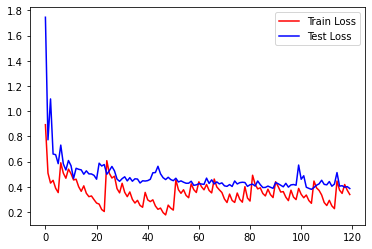

In [0]:
val_loss = []
for i in range(len(history_1)):
  val_loss.append(history_1[i].history['val_loss'])

flat_val_loss = []
for sublist in val_loss:
    for item in sublist:
        flat_val_loss.append(item)
loss = []
for i in range(len(history_1)):
  loss.append(history_1[i].history['loss'])

flat_loss = []
for sublist in loss:
    for item in sublist:
        flat_loss.append(item)

import matplotlib.pyplot as plt


plt.plot(flat_loss, 'r')
plt.plot(flat_val_loss, 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

In [0]:
val_loss = []
for i in range(len(history_1)):
  val_loss.append(history_1[i].history['val_miou'])

flat_val_loss = []
for sublist in val_loss:
    for item in sublist:
        flat_val_loss.append(item)

loss = []
for i in range(len(history_1)):
  loss.append(history_1[i].history['miou'])

flat_loss = []
for sublist in loss:
    for item in sublist:
        flat_loss.append(item)

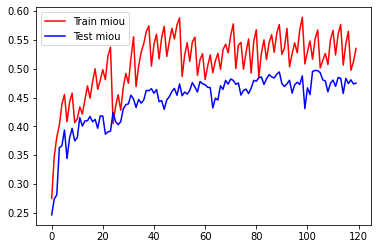

In [0]:
import matplotlib.pyplot as plt


plt.plot(flat_loss, 'r')
plt.plot(flat_val_loss, 'b')
plt.legend({'Train miou': 'r', 'Test miou':'b'})
plt.show()

In [0]:
val_loss = []
for i in range(len(history_1)):
  val_loss.append(history_1[i].history['val_accuracy'])

flat_val_loss = []
for sublist in val_loss:
    for item in sublist:
        flat_val_loss.append(item)

loss = []
for i in range(len(history_1)):
  loss.append(history_1[i].history['accuracy'])

flat_loss = []
for sublist in loss:
    for item in sublist:
        flat_loss.append(item)

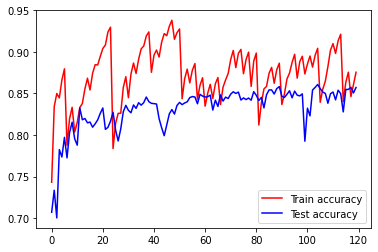

In [0]:
import matplotlib.pyplot as plt


plt.plot(flat_loss, 'r')
plt.plot(flat_val_loss, 'b')
plt.legend({'Train accuracy': 'r', 'Test accuracy':'b'})
plt.show()

In [0]:
x_path = paths.list_images("/content/drive/My Drive/IDD/leftImg8bit/test")
x_path = sorted(x_path)
x_path[:5],len(x_path)

(['/content/drive/My Drive/IDD/leftImg8bit/test/200/frame0199_leftImg8bit.jpg',
  '/content/drive/My Drive/IDD/leftImg8bit/test/200/frame0252_leftImg8bit.jpg',
  '/content/drive/My Drive/IDD/leftImg8bit/test/200/frame1090_leftImg8bit.jpg',
  '/content/drive/My Drive/IDD/leftImg8bit/test/200/frame1250_leftImg8bit.jpg',
  '/content/drive/My Drive/IDD/leftImg8bit/test/200/frame1457_leftImg8bit.jpg'],
 2009)

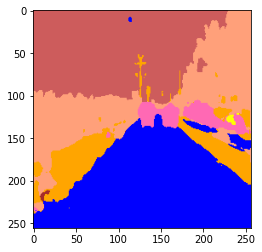

In [0]:
image_te = []
image = cv2.imread(x_path[0])
img = cv2.resize(image, (256, 256))
img = np.float32(img)  / 255 
image_te.append(img)
image_te = np.array(image_te)
result = model.predict(image_te)
result = np.argmax(result, axis=3)
colors = np.array([
    [255, 192 ,203	],      
    [255, 160, 122],     
    [255, 105, 180],      
    [205,  92,  92],        
    [255, 165,   0],    
    [255, 255,   0],      
    [165,  42,  42],     
    [0,   0, 255]           
], dtype=np.int)
image_y_te = []

color_image = np.zeros(
        (result.shape[1], result.shape[2], 3), dtype=np.int)
for i in range(8):
  color_image[result[0] == i] = colors[i]
image_y_te.append(color_image)
image_y_te = np.array(image_y_te)

from matplotlib import image
from matplotlib import pyplot

pyplot.imshow(color_image)
pyplot.show()

uint8
(1080, 1920, 3)


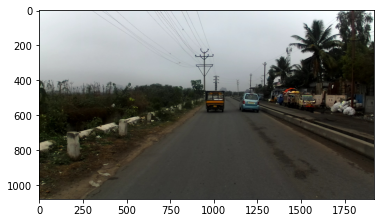

In [0]:
# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
data = image.imread(x_path[0])
# summarize shape of the pixel array
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
pyplot.imshow(data)
pyplot.show()

In [0]:
image_te = []
image = cv2.imread(x_path[1])
img = cv2.resize(image, (256, 256))
img = np.float32(img)  / 255 
image_te.append(img)
image_te = np.array(image_te)
result = model.predict(image_te)
result = np.argmax(result, axis=3)
colors = np.array([
    [255, 192 ,203	],      
    [255, 160, 122],     
    [255, 105, 180],      
    [205,  92,  92],        
    [255, 165,   0],    
    [255, 255,   0],      
    [165,  42,  42],     
    [0,   0, 255]           
], dtype=np.int)
image_y_te = []

color_image = np.zeros(
        (result.shape[1], result.shape[2], 3), dtype=np.int)
for i in range(8):
  color_image[result[0] == i] = colors[i]
image_y_te.append(color_image)
image_y_te = np.array(image_y_te)

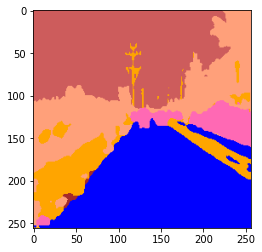

In [0]:

from matplotlib import image
from matplotlib import pyplot

pyplot.imshow(color_image)
pyplot.show()

uint8
(1080, 1920, 3)


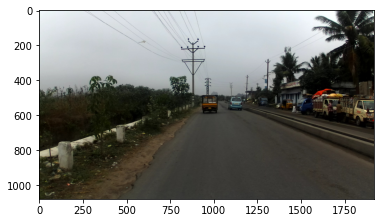

In [0]:
# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
data = image.imread(x_path[1])
# summarize shape of the pixel array
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
pyplot.imshow(data)
pyplot.show()

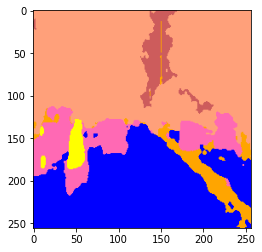

In [0]:
image_te = []
image = cv2.imread(x_path[300])
img = cv2.resize(image, (256, 256))
img = np.float32(img)  / 255 
image_te.append(img)
image_te = np.array(image_te)
result = model.predict(image_te)
result = np.argmax(result, axis=3)
colors = np.array([
    [255, 192 ,203	],      
    [255, 160, 122],     
    [255, 105, 180],      
    [205,  92,  92],        
    [255, 165,   0],    
    [255, 255,   0],      
    [165,  42,  42],     
    [0,   0, 255]           
], dtype=np.int)
image_y_te = []

color_image = np.zeros(
        (result.shape[1], result.shape[2], 3), dtype=np.int)
for i in range(8):
  color_image[result[0] == i] = colors[i]
image_y_te.append(color_image)
image_y_te = np.array(image_y_te)

from matplotlib import image
from matplotlib import pyplot

pyplot.imshow(color_image)
pyplot.show()

uint8
(1080, 1920, 3)


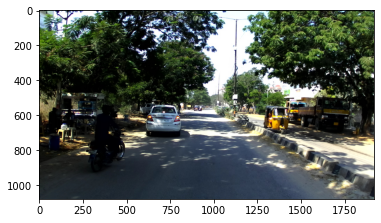

In [0]:
# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
data = image.imread(x_path[300])
# summarize shape of the pixel array
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
pyplot.imshow(data)
pyplot.show()

In [0]:
%cd /content/drive/My Drive/IDD/Output
!pwd

/content/drive/My Drive/IDD/Output
/content/drive/My Drive/IDD/Output


In [0]:
from PIL import Image
from IPython.display import clear_output
for test_img in tqdm(range(len(x_path))):
    clear_output(wait=True)
    image = cv2.imread(x_path[test_img])
    img = cv2.resize(image, (256, 256))
    img = np.float32(img)  / 255 

    image = np.array(img)
    result = model.predict(np.expand_dims(image,axis = 0))
    result = np.argmax(result, axis=3)
    colors = np.array([
    [255, 192 ,203],      
    [255, 160, 122],     
    [255, 105, 180],      
    [205,  92,  92],        
    [255, 165,   0],    
    [255, 255,   0],      
    [165,  42,  42],     
    [0,   0, 255]           
  ], dtype=np.int)
    color_image = np.zeros(
          (result.shape[1], result.shape[2], 3), dtype=np.int)
    for i in range(8):
        color_image[result[0] == i] = colors[i]
    from matplotlib import image
    from matplotlib import pyplot
    #pyplot.figure(figsize=(30, 30))
    fig, (ax0, ax1) = pyplot.subplots(ncols=2,figsize=(15,15))
    
    #ax0.figure(figsize=(10, 10))
    ax0.axis('off')
    ax0.imshow(color_image)
    import matplotlib.image as mpimg
    #ax1.figure(figsize=(10, 10))
    ax1.axis('off')
    ax1.imshow(mpimg.imread(x_path[test_img]))
    pyplot.savefig(x_path[test_img].split('/')[-1])
    pyplot.show()
    print("Write to:"+x_path[test_img].split('/')[-1])


Buffered data was truncated after reaching the output size limit.